In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import seaborn
seaborn.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 7

import theano
import numpy as np
import logging
log = logging.getLogger()
log.setLevel("DEBUG")

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


# Kaggle Grasp Lift Competition Set

We show how to use the nets on the [Kaggle Grasp Lift Competition](https://www.kaggle.com/c/grasp-and-lift-eeg-detection).

This dataset has several properties different from typical trial-based motor imagery datasets:

* You need to train and predict for every sample
* There are 6 classes (HandStart, FirstDigitTouch, BothStartLoadPhase, LiftOff, Replace, BothReleased)
* All classes appear in a single trial, in the chronological order as above (with some classes overlapping)
* Due to overlap, a sample can have several classes => multi-label dataset
* The set is highly imbalanced: For any class, only 2.5% of the samples belong to that class
* Potentials such as Visually Evoked Potentials can help decoding (see [this script and explanation](https://www.kaggle.com/alexandrebarachant/grasp-and-lift-eeg-detection/visual-evoked-potential-vep/notebook))
* The [mean over all classes of the area under the curve](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/details/evaluation) of the predictions and targets is the evaluation metric

We will go thorugh several steps towards our final model, which addresses the properties above.

1. We start with a simple fully connected layer just using one sample for prediction as a sanity check
2. We cut out windows of length 269 for each sample, and push them through our rawnet, showing this is quite slow
3. We show a faster version of the rawnet which predicts multiple samples at the same time
4. We address the class imbalances by weighting the loss higher for the samples with a label/class
5. We adress the class imbalances further by oversampling timeblocks with morelabels

## Single Sample Fully Connected

First we load the set for subject 1. This assumes you have the kaggle train data under `data/kaggle-grasp-lift/train/`. The preprocessing of the set is hardcoded to be a subsampling to 250 Hz only, no time-domain filtering (e.g. highpass) to avoid time shifts that might make it harder to predict the samples correctly (you are never allowed to use data from the future and therefore restricted to causal/forward filters).

In [3]:
from braindecode.datasets.grasp_lift import KaggleGraspLiftSet
from braindecode.datahandling.splitters import KaggleTrainValidTestSplitter
# Note that our best results are actually without resampling
# however resampling will make this notebook run faster
kaggle_set = KaggleGraspLiftSet('data/kaggle-grasp-lift/', i_subject=1,
                                resample_half=True, standardize=False)
kaggle_set.load()

INFO:braindecode.datasets.grasp_lift:Loading data...
INFO:braindecode.datasets.grasp_lift:Resampling data...
INFO:braindecode.datasets.grasp_lift:..Done.


Now we create the model.

In [4]:
import lasagne
import theano.tensor as T
from lasagne.nonlinearities import sigmoid
from numpy.random import RandomState
# Make sure that everything is reproducible by initializing the random generator
lasagne.random.set_rng(RandomState(23903823)) 

# Input is 4d, last 2 dimensions will be empty in our case.
input_var = T.tensor4('inputs')

# The layers itself:
network = lasagne.layers.InputLayer(shape=[None, 32,1,1],
                                    input_var=input_var)
network = lasagne.layers.DenseLayer(network, num_units=6,nonlinearity=sigmoid, name='dense')

We create and run the experiment, we just run it for 5 epochs (until the early stop). We can use a large batch size since one batch only has 32 values (from the 32 channels). Note that the "misclass" values now actually are 1 - the mean auc values described above.

In [5]:
from braindecode.veganlasagne.monitors import LossMonitor, MisclassMonitor, RuntimeMonitor, AUCMeanMisclassMonitor
from braindecode.experiments.experiment import Experiment
from braindecode.datahandling.preprocessing import OnlineAxiswiseStandardize
from braindecode.datahandling.batch_iteration import BalancedBatchIterator
from braindecode.veganlasagne.update_modifiers import MaxNormConstraint
from braindecode.veganlasagne.stopping import MaxEpochs

# These ones will remain the same for most of the experiments
kaggle_splitter = KaggleTrainValidTestSplitter()
online_preproc = OnlineAxiswiseStandardize(axis=['c'])
updates_adam = lasagne.updates.adam

dataset_iterator = BalancedBatchIterator(batch_size=200)

loss_var_func = lasagne.objectives.binary_crossentropy

updates_modifier = MaxNormConstraint({
            'dense': 2.0})
stop_criterion = MaxEpochs(num_epochs=5)



monitors=[LossMonitor(), AUCMeanMisclassMonitor(), RuntimeMonitor()]

exp = Experiment(network, kaggle_set, kaggle_splitter, online_preproc,
          dataset_iterator, loss_var_func, updates_adam, 
                 updates_modifier, monitors, stop_criterion)
exp.setup()
exp.run()

INFO:braindecode.experiments.experiment:Layers...
INFO:braindecode.experiments.experiment:InputLayer
INFO:braindecode.experiments.experiment:[None, 32, 1, 1]
INFO:braindecode.experiments.experiment:DenseLayer
INFO:braindecode.experiments.experiment:(None, 6)
INFO:braindecode.experiments.experiment:Create theano functions...
INFO:braindecode.veganlasagne.update_modifiers:Constraining dense to norm 2.00
INFO:braindecode.experiments.experiment:Done.
INFO:braindecode.experiments.experiment:Run until first stop...
INFO:braindecode.experiments.experiment:Split/Preprocess datasets...
INFO:braindecode.experiments.experiment:...Done
INFO:braindecode.experiments.experiment:Epoch 0
INFO:braindecode.experiments.experiment:train_loss           0.84786
INFO:braindecode.experiments.experiment:valid_loss           0.87418
INFO:braindecode.experiments.experiment:test_loss            0.90467
INFO:braindecode.experiments.experiment:train_misclass       0.52541
INFO:braindecode.experiments.experiment:vali

As we see it does learn something, so our sanity check is fine. The error might go down even further, but we do not expect this model to be competitive with models that use more than one samples to predict.
Note that there is quite a large difference between the time for the updates and the runtime for an epoch. This is in part because the auc computation takes quite some time.

## Samplewise Rawnet

We cut out windows for each sample. We could do this online, but we want to show that this way of training is quite slow and we don't want this cutting to interfere with our runtime.

Since it will be quite slow, we will only use 100000 samples, which is about 1/7th of the dataset. The input length of 129 is a little more than 500 ms for our 250 Hz sampling rate.

In [18]:
from braindecode.datasets.pylearn import DenseDesignMatrixWrapper
input_time_length = 129
# add axes to have fourdimensioal shape expected for input
# (before it is only time x chans axes)
train_topo = np.concatenate(kaggle_set.train_X_series)[:,:,np.newaxis,np.newaxis]
samples_to_predict = 100000
complete_topo = np.ones((samples_to_predict, 32, input_time_length, 1), dtype=np.float32)
for i_trial, i_start_sample in enumerate(xrange(samples_to_predict)):
    end_sample = i_start_sample+input_time_length
    complete_topo[i_trial] = train_topo[i_start_sample:end_sample,:].swapaxes(0,2)
    
# we can only start predicting the input_time_length's sample, so offset the y values
y = np.concatenate(kaggle_set.train_y_series)
y_predicted = y[input_time_length-1:samples_to_predict+input_time_length-1]
restricted_dataset = DenseDesignMatrixWrapper(
    topo_view=complete_topo, y=y_predicted, axes=('b','c',0,1))

We create the rawnet, note that we no long use dropout between the first two conv layers.

In [19]:
from lasagne.nonlinearities import softmax, identity
from numpy.random import RandomState
from braindecode.veganlasagne.nonlinearities import safe_log
from braindecode.veganlasagne.pool import SumPool2dLayer

lasagne.random.set_rng(RandomState(23903823))

input_var = T.tensor4('inputs')
network = lasagne.layers.InputLayer(shape=[None, 32,input_time_length,1], input_var=input_var)
# we have to switch channel dimension to height axis to not squash/convolve them away
network = lasagne.layers.DimshuffleLayer(network, pattern=(0,3,2,1))
network = lasagne.layers.Conv2DLayer(network, num_filters=20,filter_size=[30, 1], nonlinearity=identity,
                                    name='time_conv')
network = lasagne.layers.Conv2DLayer(network, num_filters=20,filter_size=[1, 32], nonlinearity=T.sqr,
                                    name='spat_conv')
network = SumPool2dLayer(network, pool_size=(50,1), stride=(10,1), mode='average_exc_pad')
network = lasagne.layers.NonlinearityLayer(network, nonlinearity=safe_log)
network = lasagne.layers.DropoutLayer(network, p=0.5)
network = lasagne.layers.DenseLayer(network, num_units=6,nonlinearity=sigmoid, name='final_dense')

We setup and run the experiment again.

In [20]:
from braindecode.datahandling.splitters import FixedTrialSplitter
from braindecode.datahandling.preprocessing import NoPreprocessing
from braindecode.veganlasagne.update_modifiers import MaxNormConstraint

dataset_splitter = FixedTrialSplitter(n_train_trials=70000, valid_set_fraction=0.2)
dataset_iterator = BalancedBatchIterator(batch_size=200)
loss_var_func = lasagne.objectives.binary_crossentropy

updates_modifier = MaxNormConstraint({
            'time_conv': 2.0,
            'spat_conv': 2.0,
            'final_dense': 0.5,
    })

monitors=[LossMonitor(), AUCMeanMisclassMonitor(), RuntimeMonitor()]


exp = Experiment(network, restricted_dataset, dataset_splitter, online_preproc,
          dataset_iterator, loss_var_func, updates_adam, updates_modifier, monitors, stop_criterion)
exp.setup()
exp.run()

INFO:braindecode.experiments.experiment:Layers...
INFO:braindecode.experiments.experiment:InputLayer
INFO:braindecode.experiments.experiment:[None, 32, 129, 1]
INFO:braindecode.experiments.experiment:DimshuffleLayer
INFO:braindecode.experiments.experiment:(None, 1, 129, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 100, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 100, 1)
INFO:braindecode.experiments.experiment:SumPool2dLayer
INFO:braindecode.experiments.experiment:(None, 20, 6, 1)
INFO:braindecode.experiments.experiment:NonlinearityLayer
INFO:braindecode.experiments.experiment:(None, 20, 6, 1)
INFO:braindecode.experiments.experiment:DropoutLayer
INFO:braindecode.experiments.experiment:(None, 20, 6, 1)
INFO:braindecode.experiments.experiment:DenseLayer
INFO:braindecode.experiments.experiment:(None, 6)
INFO:braindecode.experiments.experiment:Create theano functions.

As we see this is now already taking > 20 seconds per epoch, which would translate to >140 seconds for the whole dataset, possibly more since we might then no longer be able to precut all the time windows due to memory problems.

We could decrease the runtime by increasing the batch size, however I tried a batch size of 2000 and it only decreased the runtime to 15 seconds, while slowing down the misclass decrease per epoch (still around 0.24 after 5 epochs).

## Multiple Predictions Net

One way to speed the training up is to avoid multiple computations for neighbouring samples. Think of two neighbouring samples, their input windows have an overlap of 128 samples. For the lowest layer of the convnet, the kernel will be multiplied with the same samples twice for all but one of the input samples.
Similarly, for a sample two timesteps away, all but two kernel-input multiplications are the same, and so on.
So if you are willing to make updates on neighbouring samples at the same time, you can speed up the entire training a lot. Theoretically the maximum speedup factor for the lowest layer would be $\text{n_input_window} - \text{n_filter_size} + 1$ for valid convolutions. So in our case, if we stuck with this input window, we could get a speedup factor of maximum 129-29 = 99 (that's assuming we predict an entire infite dataset at once, but the factor will not decrease too much for realistic values).

In other words, for a net trained this way, you can increase the input window length at almost no cost.

Practically, to use/train the net this way, you have to change the code in this way:

* Set all strides in the "0"-dim to 1
* Put a StrideReshapeLayer after every layer that had a stride before.
* Replace the final dense layer by a Conv2DLayer. The filter size of the final conv layer determines the size of your input window. 
* Put a FinalReshapeLayer after the replaced final dense layer (also you can move the nonlinearity of the dense layer into its own nonlinearity layer. I think this is only really necessary if the nonlinearity is not elementwise, like softmax, but it also won't hurt to always do it). 

In our case we will have an input window of 269 samples, so a lttile more than 1 second. 


In [21]:
from lasagne.nonlinearities import identity
from braindecode.veganlasagne.layers import FinalReshapeLayer, StrideReshapeLayer

lasagne.random.set_rng(RandomState(23903823))
input_time_length = 1000
def get_multiple_pred_raw_net(input_time_length):
    """Put into function to reuse it layer"""
    input_var = T.tensor4('inputs')
    network = lasagne.layers.InputLayer(shape=[None, 32,input_time_length,1], input_var=input_var)
    # we have to switch channel dimension to height axis to not squash/convolve them away
    network = lasagne.layers.DimshuffleLayer(network, pattern=(0,3,2,1))

    network = lasagne.layers.Conv2DLayer(network, num_filters=20,filter_size=[30, 1], nonlinearity=identity,
                                        name='time_conv')
    network = lasagne.layers.Conv2DLayer(network, num_filters=20,filter_size=[1, 32], nonlinearity=T.sqr,
                                        name='spat_conv')

    network = SumPool2dLayer(network, pool_size=(50,1), stride=(1,1), mode='average_exc_pad')

    network = StrideReshapeLayer(network, n_stride=10)
    network = lasagne.layers.NonlinearityLayer(network, nonlinearity=safe_log)
    network = lasagne.layers.DropoutLayer(network, p=0.5)

    network = lasagne.layers.Conv2DLayer(network, num_filters=6, filter_size=[6, 1], nonlinearity=identity,
                                        name='final_dense')
    network = FinalReshapeLayer(network)
    network = lasagne.layers.NonlinearityLayer(network, nonlinearity=sigmoid)
    return network

network = get_multiple_pred_raw_net(input_time_length)

We also need to supply the number of predicted samples per input and the input time length to our monitor and use a different iterator. Keep in mind that per input, we now make $\text{input_time_length} - \text{input_time_window} = \text{n_sample_preds} = 872$ predictions. 
So we can use:

* a larger input time length to use larger time blocks and speed up the training (and risk some overfitting to shared characteristics of the samples of particular timeblocks)
* a larger batch size to have more different time blocks and somewhat alleviate the overfitting risk

In [22]:
from braindecode.datahandling.batch_iteration import CntWindowsFromCntIterator
from braindecode.veganlasagne.layers import get_n_sample_preds
stop_criterion = MaxEpochs(5)
n_sample_preds = get_n_sample_preds(network)
dataset_iterator = CntWindowsFromCntIterator(batch_size=20, input_time_length=input_time_length,
                                             n_sample_preds=n_sample_preds)
loss_var_func = lasagne.objectives.binary_crossentropy

updates_modifier = MaxNormConstraint({
            'time_conv': 2.0,
            'spat_conv': 2.0,
            'final_dense': 0.5,
    })

monitors=[LossMonitor(), AUCMeanMisclassMonitor(input_time_length=input_time_length, n_sample_preds=n_sample_preds),
          RuntimeMonitor()]


exp = Experiment(network, kaggle_set, kaggle_splitter, online_preproc,
          dataset_iterator, loss_var_func, updates_adam, updates_modifier, monitors, stop_criterion)
exp.setup()
exp.run()

INFO:braindecode.experiments.experiment:Layers...
INFO:braindecode.experiments.experiment:InputLayer
INFO:braindecode.experiments.experiment:[None, 32, 1000, 1]
INFO:braindecode.experiments.experiment:DimshuffleLayer
INFO:braindecode.experiments.experiment:(None, 1, 1000, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 971, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 971, 1)
INFO:braindecode.experiments.experiment:SumPool2dLayer
INFO:braindecode.experiments.experiment:(None, 20, 922, 1)
INFO:braindecode.experiments.experiment:StrideReshapeLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:NonlinearityLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:DropoutLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:Co

We see quite fast times now, less than 6 seconds for an epoch on the entire dataset.

## Loss Reweighting

Let's see how bad the imbalances exactly are:

In [28]:
all_samples  = y.shape[0]
targets_by_class = np.sum(y, axis=0)
non_targets_by_class = (all_samples - targets_by_class)
non_targets_by_class / targets_by_class.astype(np.float32)

array([ 35.47112821,  35.47112821,  35.47112821,  35.47112821,
        35.47112821,  35.47112821])

So we have a factor of 35 more non targets than targets for each class.
We want to reweight the loss so that the sum of the loss for the targets is as high as the sum of the loss for the non-targets. Also, I want to not affect the sum of the overall loss, although I am not sure this is necessary (probably not, as adam can deal with a rescaling of the gradients and rescaled loss should simply lead to rescaling of gradients?). Although probably not necessary, I will put the derivation here how I calculate the weights for the target and non-target losses just for documentation:

Given ($0_{loss}, 1_{loss}$  are sums of losses for targets und non-targets, assuming all samples have the same loss):

$0_{loss} = \text{imbalance_factor} \cdot 1_{loss}$

Wanted:

$w_0 \cdot 0_{loss} = w_1 \cdot 1_{loss}$ and

$w_0 \cdot 0_{loss} + w_1 \cdot 1_{loss} = 0_{loss} + 1_{loss} $

It follows:

$w_0 \cdot \text{imbalance_factor} \cdot 1_{loss} = w_1 \cdot 1_{loss}$

$w_0 \cdot \text{imbalance_factor} \cdot 1_{loss} = 0_{loss} + 1_{loss} - w_0 \cdot 0_{loss}$

$w_0 \cdot \text{imbalance_factor} \cdot 1_{loss} = \text{imbalance_factor} \cdot 1_{loss} + 1_{loss} - w_0 \cdot  \text{imbalance_factor} \cdot 1_{loss}$

$w_0 \cdot \text{imbalance_factor} = \text{imbalance_factor} + 1 - w_0 \cdot  \text{imbalance_factor}$

$2 \cdot w_0 \cdot \text{imbalance_factor} = \text{imbalance_factor} + 1$

$ w_0 = \frac{\text{imbalance_factor} + 1}{2 \cdot \text{imbalance_factor}}$

$ w_1 = \frac{\text{imbalance_factor} + 1}{2}$




In [29]:
from braindecode.util import FuncAndArgs

lasagne.random.set_rng(RandomState(23903823))
input_time_length = 1000
network = get_multiple_pred_raw_net(input_time_length)

stop_criterion = MaxEpochs(5)
n_sample_preds = get_n_sample_preds(network)
dataset_iterator = CntWindowsFromCntIterator(batch_size=20, input_time_length=input_time_length,
                                             n_sample_preds=n_sample_preds)

def weighted_binary_cross_entropy(preds, targets, imbalance_factor):
    factor_no_target = (imbalance_factor + 1) / (2.0 *  imbalance_factor)
    factor_target = (imbalance_factor + 1) / 2.0
    loss = lasagne.objectives.binary_crossentropy(preds, targets)
    loss = factor_no_target * loss + loss * targets * factor_target
    return loss

weighted_loss_var_func = FuncAndArgs(weighted_binary_cross_entropy, imbalance_factor=35)

updates_modifier = MaxNormConstraint({
            'time_conv': 2.0,
            'spat_conv': 2.0,
            'final_dense': 0.5,
    })

from braindecode.veganlasagne.monitors import AUCMeanMisclassMonitor
monitors=[LossMonitor(), 
          AUCMeanMisclassMonitor(input_time_length=input_time_length, n_sample_preds=n_sample_preds),
          RuntimeMonitor()]


exp = Experiment(network, kaggle_set, kaggle_splitter, online_preproc,
          dataset_iterator, weighted_loss_var_func, updates_adam, updates_modifier, monitors, stop_criterion)
exp.setup()
exp.run()

INFO:braindecode.experiments.experiment:Layers...
INFO:braindecode.experiments.experiment:InputLayer
INFO:braindecode.experiments.experiment:[None, 32, 1000, 1]
INFO:braindecode.experiments.experiment:DimshuffleLayer
INFO:braindecode.experiments.experiment:(None, 1, 1000, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 971, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 971, 1)
INFO:braindecode.experiments.experiment:SumPool2dLayer
INFO:braindecode.experiments.experiment:(None, 20, 922, 1)
INFO:braindecode.experiments.experiment:StrideReshapeLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:NonlinearityLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:DropoutLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:Co

We note that the auc/misclass goes down much faster and the loss much slower, as we intended. In the end already we have a twice lower auc/misclass than before (0.07 vs 0.14).

## Oversampling

Another way to combat imbalances is to train more on the targets than on the non targets. Since we now use timeblocks of several samples, I do not know a principled way to oversample, so I resort to this heuristic:

1. Compute number of targets in each timeblock (timeblock: samples that will be trained on together)
2. If a timeblock has more targets in it than the mean for all timeblocks, train on it proportionally more often, i.e., if it has twice as many targets, train on it twice, if it has three times as many, train on it three times etc.

Since these are additional updates, we have more updates per epoch, so results are unfortunately not directly comparable. Also it remains unclear if we should then readapt the loss, in this case I reweight it as before and also oversample.... 

The only difference in the code now is the ```oversample_targets=True``` when creating the dataset iterator.

In [31]:
lasagne.random.set_rng(RandomState(23903823))
input_time_length = 1000
network = get_multiple_pred_raw_net(input_time_length)

stop_criterion = MaxEpochs(5)
n_sample_preds = get_n_sample_preds(network)
dataset_iterator = CntWindowsFromCntIterator(batch_size=20, input_time_length=input_time_length,
                                             n_sample_preds=n_sample_preds, oversample_targets=True)

def weighted_binary_cross_entropy(preds, targets, imbalance_factor):
    factor_no_target = (imbalance_factor + 1) / (2.0 *  imbalance_factor)
    factor_target = (imbalance_factor + 1) / 2.0
    loss = lasagne.objectives.binary_crossentropy(preds, targets)
    loss = factor_no_target * loss + loss * targets * factor_target
    return loss

weighted_loss_var_func = FuncAndArgs(weighted_binary_cross_entropy, imbalance_factor=35)

updates_modifier = MaxNormConstraint({
            'time_conv': 2.0,
            'spat_conv': 2.0,
            'final_dense': 0.5,
    })

from braindecode.veganlasagne.monitors import AUCMeanMisclassMonitor
monitors=[LossMonitor(), 
          AUCMeanMisclassMonitor(input_time_length=input_time_length, n_sample_preds=n_sample_preds),
          RuntimeMonitor()]


exp = Experiment(network, kaggle_set, kaggle_splitter, online_preproc,
          dataset_iterator, weighted_loss_var_func, updates_adam, updates_modifier, monitors, stop_criterion)
exp.setup()
exp.run()

INFO:braindecode.experiments.experiment:Layers...
INFO:braindecode.experiments.experiment:InputLayer
INFO:braindecode.experiments.experiment:[None, 32, 1000, 1]
INFO:braindecode.experiments.experiment:DimshuffleLayer
INFO:braindecode.experiments.experiment:(None, 1, 1000, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 971, 32)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 20, 971, 1)
INFO:braindecode.experiments.experiment:SumPool2dLayer
INFO:braindecode.experiments.experiment:(None, 20, 922, 1)
INFO:braindecode.experiments.experiment:StrideReshapeLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:NonlinearityLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:DropoutLayer
INFO:braindecode.experiments.experiment:(None, 20, 93, 1)
INFO:braindecode.experiments.experiment:Co

As we see, the net does have an even better auc rate now, but we cannot tell if this is due to oversampling or simply due to more updates.
So to test this properly we would need to use much more epochs/real early stopping :)

## Weight visualization

If we look at the weights, they look quite weird. Unfortunately, I do not yet have the pattern transformations for the multiple prediction net implemented, so you have to look at them for now ;) (Update: patterns are now possible to compute but atleast for other models did not look very easily interpretable)

In [32]:

params = lasagne.layers.get_all_params(network)

# Combine the weights. We have to reverse them with ::-1 to change convolution to cross-correlation
temporal_weights = params[0].get_value()[:,:,::-1,::-1]
spat_filt_weights = params[2].get_value()[:,:,::-1,::-1]

combined_weights = np.tensordot(spat_filt_weights, temporal_weights, axes=(1,0))

combined_weights = combined_weights.squeeze()
# Lets find the weights that have the largest absolute sum of weights in the softmax layer
soft_weights = params[4].get_value()
soft_weights_topo = soft_weights.transpose(1,2,3,0) # hope this is right :D #adapted fom other code
soft_sum =np.sum(np.abs(soft_weights_topo), axis=(1,2,3))
important_weights = np.argsort(soft_sum)[::-1]



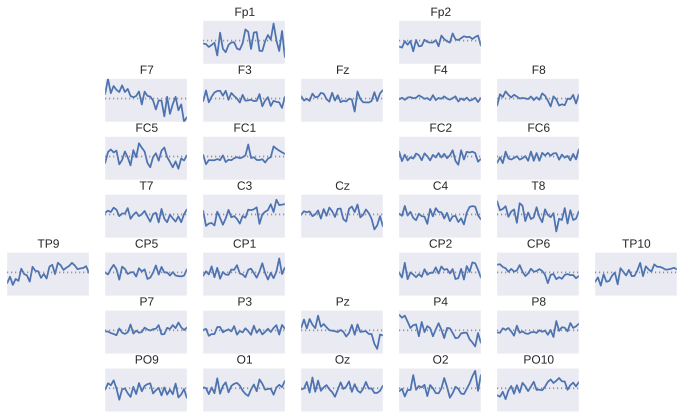

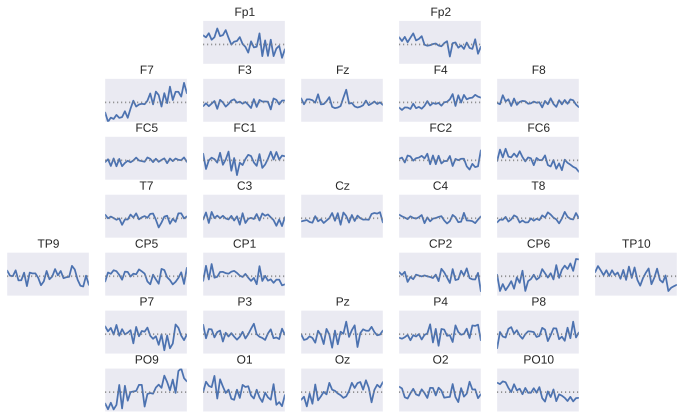

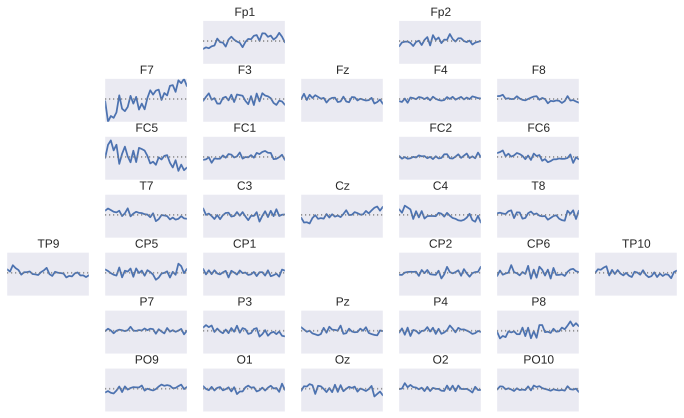

In [33]:
from braindecode.analysis.plot_util import plot_head_signals_tight
from braindecode.datasets.sensor_positions import tight_Kaggle_positions

plot_head_signals_tight(combined_weights[important_weights[0]], kaggle_set.sensor_names,
                        sensor_map=tight_Kaggle_positions)
plot_head_signals_tight(combined_weights[important_weights[1]], kaggle_set.sensor_names,
                        sensor_map=tight_Kaggle_positions)
plot_head_signals_tight(combined_weights[important_weights[2]], kaggle_set.sensor_names,
                        sensor_map=tight_Kaggle_positions)
None

## Stuff just for me :)

In [1]:
%%capture
import scikits.samplerate
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2